# (Back) tracking particles in the geomagnetic field

Following the papers:
- Soni, Kakad, Kakad - https://doi.org/10.1016/j.asr.2020.10.020
- Öztürk - https://doi.org/10.1119/1.3684537

In [1]:
from datetime import datetime
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt
# %matplotlib widget

import ppigrf

DEBUG = None # to be set later

In [2]:
## Some constants

M = 1 # nuclear mass unit u
# 1 u = 1.66e-27 kg

CHARGE = 1 # charge of the nucleus in units of the elementary charge
# 1 e = 1.6e-19 C

SPEED_OF_LIGHT = 3e8 # m/s

R_EARTH = 6.4e6 # m

# somewhat arbitrary date
DATE = datetime(2021, 3, 28)

## Conversion factor when computing the Lorentz force
# F = gamma * q * v x B
CONVERSION_FACTOR = 1.66e27 * 1.6e-19 * 1e-9
# where we also converted from nT to T
ABSOLUTE_TOLERANCE = 1e5

### Modelling the magnetic field
- as a sanity check we can use a simple homogeneous magnetic field in the z direction
$$
\mathbf{B} = B_0 \mathbf{e}_z
$$
- In the simplest approximation, the magnetic field can be modelled as a dipole field. In cartesian coordinates, it is given by:
$$
\mathbf{B}(\mathbf{r}) = -B_0 \cdot \frac{R_{earth}^3}{r^5} * \left( 3xz \cdot \mathbf{e_x} + 3yz\cdot \mathbf{e_y} + (2z^2 - x^2 - y^2)\cdot \mathbf{e_z}\right)
$$ 
TODO: check
TODO: check reference
- A far better approximation is given by the IGRF model. The IGRF model is given by a sum of spherical harmonics. The coefficients are fitted to measurements and account for time variations.

In [14]:
## helpers for IGRF, since it is given in spherical coordinates
def cartesian_to_spherical(v: np.ndarray) -> np.ndarray:
    return np.array([
        np.linalg.norm(v),
        np.degrees(np.arctan2(np.linalg.norm(v[:2]), v[2])),
        np.degrees(np.arctan2(v[1], v[0]))
    ])


#I'm lazy, so I redefine
cosd = lambda x: np.cos(np.deg2rad(x))
sind = lambda x: np.sin(np.deg2rad(x))
def B_to_cartesian(r_vec: np.ndarray, B: np.ndarray) -> np.ndarray:
    # express the spherical components of B in cartesian coordinates through the jacobian
    # (Bx, By, Bz) = J * (Br, Btheta, Bphi)
    r = r_vec[0] # though not needed
    theta = r_vec[1]
    phi = r_vec[2]
    J = np.array([
        [cosd(theta) * cosd(phi), - sind(theta) * cosd(phi), -cosd(theta) * sind(phi)],
        [cosd(theta) * sind(phi), sind(theta) * sind(phi), cosd(theta) * cosd(phi)],
        [sind(theta), cosd(theta), sind(theta)]
    ])
    J = np.array([
        [sind(theta) * cosd(phi), - cosd(theta) * cosd(phi), -sind(phi)],
        [sind(theta) * sind(phi), -cosd(theta) * sind(phi), cosd(phi)],
        [cosd(theta), 0, sind(theta)]
    ])
    B_cart = J @ B
    if DEBUG:
        print(f"norms - spherical B = {np.linalg.norm(B)}, cartesian B = {np.linalg.norm(B_cart)}")
    return B_cart


B_INTENSITY = 1e4 # nT # to be on par with the IGRF values
## Different implementations of the magnetic field
def simple_field(x):
    B = np.array([0, 0, 1]) * B_INTENSITY
    return B


def dipole_field(x):
    intensity = B_INTENSITY
    r = np.linalg.norm(x)
    B =  intensity * R_EARTH**3 / r**5 * np.array([
        3 * x[2] * x[0],
        3 * x[2] * x[1],
        2 * x[2]**2 - x[0]**2 - x[1]**2
    ])
    return B


def IGRF_field(x):
    r_vec = cartesian_to_spherical(x)
    r = r_vec[0] * 1e-3 # convert to km
    B = ppigrf.igrf_gc(r, r_vec[1], r_vec[2], DATE) # returns radial, south, east
    B = np.array(B).flatten()
    B_cart = B_to_cartesian(r_vec, B)
    if DEBUG:
        print(f"B = {B}, B_cart = {B_cart}")
    return B_cart


### Magnetic field and equation of motion
We consider **only** the effect of the magnetic field, as given by the Lorentz force:

$$
F_L = q \cdot \vec{v} \times \vec{B}(r, \theta, \phi)
$$
TODO: comment on synchrotron radiation
where:
- v is the velocity of the particle
- B is the magnetic field

The equation of motion is still given by:
$$
m \cdot \frac{d^2 \vec{r}}{dt^2} = F_L
$$
but in the relativistic case the mass is expressed as
$$
m = \gamma m_0
$$



### Integrating the equation of motion

As a starting point we can integrate the EOM and track the particle **forward in time**. The procedure is as follows:
- linearize the EOM
- integrate the EOM
- plot the trajectory

=> Doing this for every incoming particle is not feasible!


#### Backtracking
We can also track the particle **backward in time**, from the detector (eg. AMS-01). The procedure is as follows:
- modify the EOM to track the particle backward in time
    - treat the velocity as negative

In [4]:
## Functions to be integrated
def gamma_inv(v: np.ndarray) -> float:
    v = np.linalg.norm(v)
    if v > SPEED_OF_LIGHT:
        print(f"v = {v} > c, setting 1/gamma = 0")
        return 0
    return np.sqrt(1 - (v / SPEED_OF_LIGHT)**2)


def force(x: np.ndarray, v: np.ndarray, b_field_func: callable) -> np.ndarray:
    B = b_field_func(x)
    # B is now in nT, but this is absorbed in the conversion factor
    F =  CHARGE * np.cross(v, B) * CONVERSION_FACTOR
    if DEBUG:
        print(f"B = {B}")
        print(f"x = {x}")
        print(f"v = {np.linalg.norm(v)}")
        print(f"F = {F}")
    return F.flatten()


# linearized equations of motion - forward
def y_prime(t, y, b_field_func):
    # to be compatible with the scipy integrator, we need the following signature
    x = y[:3]
    v = y[3:]
    a = (gamma_inv(v) / M) * force(x, v, b_field_func)
    ydot = np.concatenate((v, a))
    if DEBUG:
        print(f"1/gamma = {gamma_inv(v)}")
        print(f"a = {a}")
        print(f"ydot: {ydot}")
    return np.concatenate((v, a))

In [5]:
## Some more helpers
def plot_trajectory(x: list[np.ndarray], labels: list[str], show_nth: int = 1, show_earth: bool = False, r_e_limit: int = 5):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    # show the trajectory (x)
    for trajectory, label in zip(x, labels):
        trajectory = trajectory / R_EARTH
        ax.plot3D(trajectory[0, ::show_nth], trajectory[1, ::show_nth], trajectory[2, ::show_nth], label=label)
        # show start and end points
        ax.scatter(trajectory[0, 0], trajectory[1, 0], trajectory[2, 0], color='green') #, label='start'
        ax.scatter(trajectory[0, -1], trajectory[1, -1], trajectory[2, -1], color='red') #, label='end'
    
    # show the earth
    if show_earth:
        u = np.linspace(0, 2 * np.pi, 100)
        v = np.linspace(0, np.pi, 100)
        x = np.outer(np.cos(u), np.sin(v))
        y = np.outer(np.sin(u), np.sin(v))
        z = np.outer(np.ones(np.size(u)), np.cos(v))
        ax.plot_surface(x, y, z, color='b', alpha=0.1)

    # set sensible view limits
    ax.set_box_aspect([1,1,1])
    ax.set_xlim(-r_e_limit, r_e_limit)
    ax.set_ylim(-r_e_limit, r_e_limit)
    ax.set_zlim(-r_e_limit, r_e_limit)
    # TODO: explain limit
    
    ax.set_xlabel('x [R_e]')
    ax.set_ylabel('y [R_e]')
    ax.set_zlabel('z [R_e]')
    # show small legend
    ax.legend(fontsize='small')
    fig.set_size_inches(10, 10)


def energy_to_speed(E: float) -> float:
    """assumes energy given in eV and returns speed in m/s"""
    mass_kg = M * 1.66e-27
    energy_j = E * 1.6e-19
    return SPEED_OF_LIGHT * np.sqrt(1 - ((mass_kg * SPEED_OF_LIGHT**2) / (mass_kg * SPEED_OF_LIGHT**2 + energy_j))**2)
    


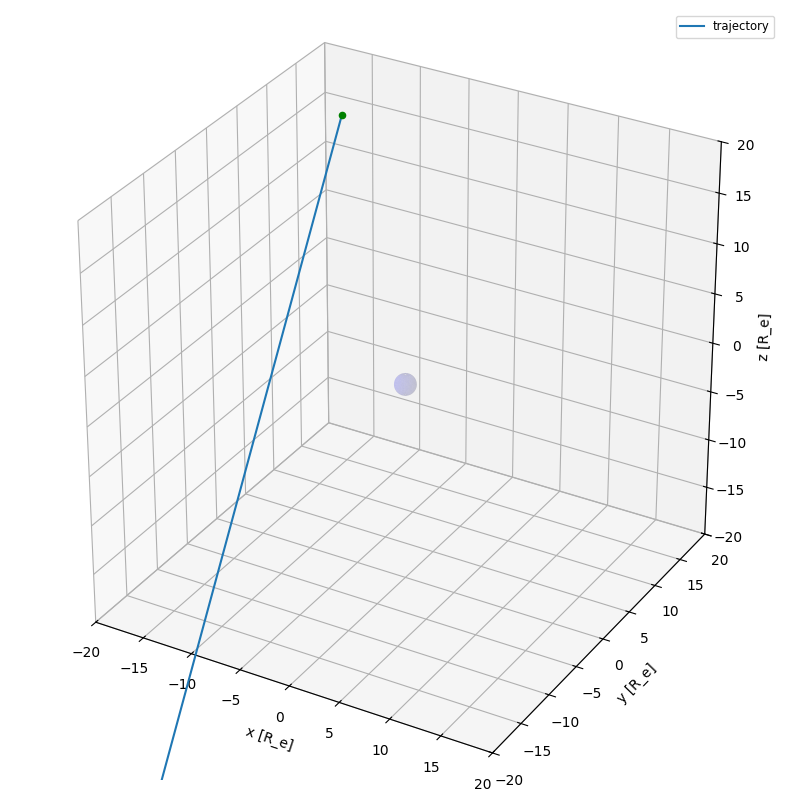

In [6]:
## ODE integration

# setup of initial conditions
# particle is deflected by the magnetic field
X_0 = [0, 1e8, 1e8]
V_0 = [-1e4, -2e4, -1e4]
Y0 = np.concatenate((X_0, V_0))
# particle cycles
X_0 = [0, 1e8, 0]
V_0 = [0, 0, 1e4]
# particle is so fast that it is barely deflected
X_0 = [-1e8, 1e8, 1e8]
V_0 = [0, -1e7, -1e8]
Y0 = np.concatenate((X_0, V_0))

TIME_RANGE = [0, 1000000]
N_STEPS = 10000
t = np.linspace(TIME_RANGE[0], TIME_RANGE[1], N_STEPS)

result = spi.solve_ivp(
    y_prime,
    t_span=TIME_RANGE,
    t_eval=t,
    y0=Y0,
    args=(dipole_field,)
    )
if not result.success:
    print("Integration failed")
    print(result.message)
    exit(1)


t_int = result.t
y_int = result.y


if DEBUG:
    print(f"Got result: {y_int.shape}")
    print(y_int[:, 0])
    print(y_int[:, 1])
    print(f"Took {result.nfev} function evaluations")

plot_trajectory([y_int[:3, :]], ["trajectory"], show_earth=True, r_e_limit=20)
# trajectory argument should be a list

In [7]:
def check_trajectory(trajectory: np.ndarray) -> str:
    if DEBUG:
        print(f"trajectory shape = {trajectory.shape}")
        print(f"norm shape = {np.linalg.norm(trajectory, axis=0).shape}")
        print(f"earth condition: {np.linalg.norm(trajectory, axis=0) < R_EARTH}")

    r = np.linalg.norm(trajectory, axis=0)
    # check if it intersects the earth
    if np.any(r < R_EARTH):
        return "Intersects the earth"
    
    # check if it goes too far
    if any(r > 5 * R_EARTH):
        return "Leaves 5R_e"

    return "Too short"

def clip_trajectory(trajectory: np.ndarray) -> np.ndarray:
    r = np.linalg.norm(trajectory, axis=0)
    idx = np.where(r < R_EARTH)[0]
    if len(idx) == 0:
        return trajectory
    print(f"Clipping at index {idx[0]}")
    return trajectory[:, :idx[0]]

In [8]:
def multi_tracking(
        b_field_function: callable,
        # either we explicitly set the initial conditions
        y_0: list[np.ndarray] = None,
        # or we generate them randomly
        x_0_val: float = 7e6, # close to the earth
        v_0_val: float = energy_to_speed(5e6), # 5 MeV
        seed: int = None,
        repetitions: int = 1,
        time_range: list = [0, 50],
        n_steps: int = 10000,
        do_clip_trajectory: bool = False,
        write_to_file: bool = False,
):
    if seed:
        np.random.seed(seed)

    if y_0 is None:
        y_0 = []
        print("Using random initial conditions")
        for _ in range(repetitions):
            x = np.random.rand(3) * 2 - 1 # random vector in [-1, 1]
            x = x / np.linalg.norm(x) * x_0_val
            v = np.random.rand(3) * 2 - 1 # random vector in [-1, 1]
            v = v / np.linalg.norm(v) * v_0_val
            y = np.concatenate((x, v))
            y_0.append(y)


    trajectories = []
    labels = []
    for Y0 in y_0:
        if DEBUG:
            print(f"X_0 = {Y0[3:]}, |X_0| = {np.linalg.norm(Y0[3:]):.2E}")
            print(f"V_0 = {Y0[:3]}, |V_0| = {np.linalg.norm(Y0[:3]):.2E}")
        
        t = np.linspace(time_range[0], time_range[1], n_steps)
        sol = spi.solve_ivp(
            lambda t, y: -y_prime(-t, y, b_field_function), # formulate the problem backward
            t_span = [time_range[1], time_range[0]],
            t_eval= t[::-1],
            y0 = Y0,
            method='RK45',
            atol=ABSOLUTE_TOLERANCE
        )
        traj = sol.y[:3, :]

        check = check_trajectory(traj)
        if do_clip_trajectory and "Intersects" in check:
            traj = clip_trajectory(traj)

        trajectories.append(traj)
        labels.append(check)
        if DEBUG:
            print(f"Result has shape {y_int.shape}")
            print(f"Result: {y_int[:, 0]}")
            print(f"Result: {y_int[:, 1]}")
            print(f"Result: {y_int[:, -1]}")
    
    plot_trajectory(trajectories, labels, show_earth=True, r_e_limit=5)
    # CAUTION: start is the start of the backward integration -> so end was technically earlier



v = 344542899.796119 > c, setting 1/gamma = 0
v = 344841748.5986058 > c, setting 1/gamma = 0
v = 481150105.42381305 > c, setting 1/gamma = 0
v = 2565331025.8977494 > c, setting 1/gamma = 0
v = 7087924823.896221 > c, setting 1/gamma = 0
v = 6426635624.30009 > c, setting 1/gamma = 0
v = 324086920.389382 > c, setting 1/gamma = 0
v = 832385994.0599232 > c, setting 1/gamma = 0
v = 2300113882.0409102 > c, setting 1/gamma = 0
v = 2085521445.0100877 > c, setting 1/gamma = 0
v = 417676278.54411155 > c, setting 1/gamma = 0
v = 512536806.7169376 > c, setting 1/gamma = 0
v = 371740416.775612 > c, setting 1/gamma = 0
v = 398044252.54979306 > c, setting 1/gamma = 0
v = 316875470.23864037 > c, setting 1/gamma = 0
v = 364097421.68445885 > c, setting 1/gamma = 0
v = 307068065.7261611 > c, setting 1/gamma = 0
v = 329634151.4587222 > c, setting 1/gamma = 0
v = 366408635.6805204 > c, setting 1/gamma = 0
v = 542064347.5270226 > c, setting 1/gamma = 0
Clipping at index 3


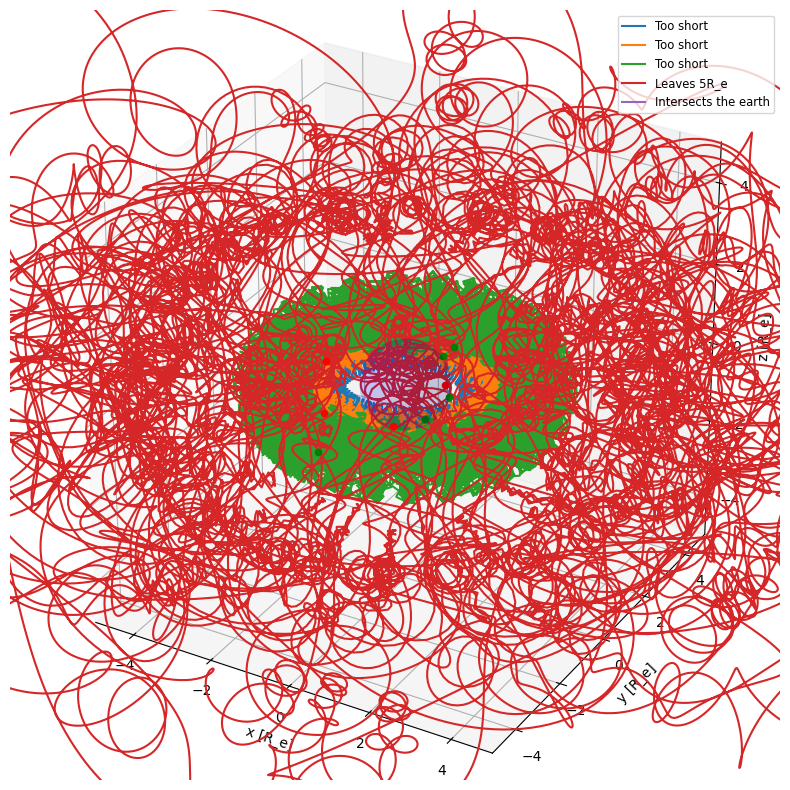

In [ ]:
# Some nice examples
Y = []

# small shell around the earth
X0 = np.array([3.8e6, 3.8e6, 3.8e6])
V0 = np.array([0, -5e5, -2e6])
Y0 = np.concatenate((X0, V0))
Y.append(Y0)

# medium shell around the earth
X0 = np.array([5e6, 5e6, 5e6])
V0 = np.array([0, -5e5, -1e6])
Y0 = np.concatenate((X0, V0))
Y.append(Y0)

# large+stable shell around the earth
X0 = np.array([-9e6, -9e6, -9e6])
V0 = np.array([0, -1e6, 1e6])
Y0 = np.concatenate((X0, V0))
Y.append(Y0)

# large+instable shell around the earth
X0 = np.array([2e6, 2e6, -6e6])
V0 = np.array([1e4, 1e4, -1e3])
Y0 = np.concatenate((X0, V0))
Y.append(Y0)

# particle leaves rather quickly
X0 = np.array([7e6, 0, 0])
V0 = np.array([0, -4e7, +4e7])
Y0 = np.concatenate((X0, V0))
Y.append(Y0)

multi_tracking(dipole_field, y_0=Y, time_range=[0, 100], n_steps=4000, do_clip_trajectory=True)

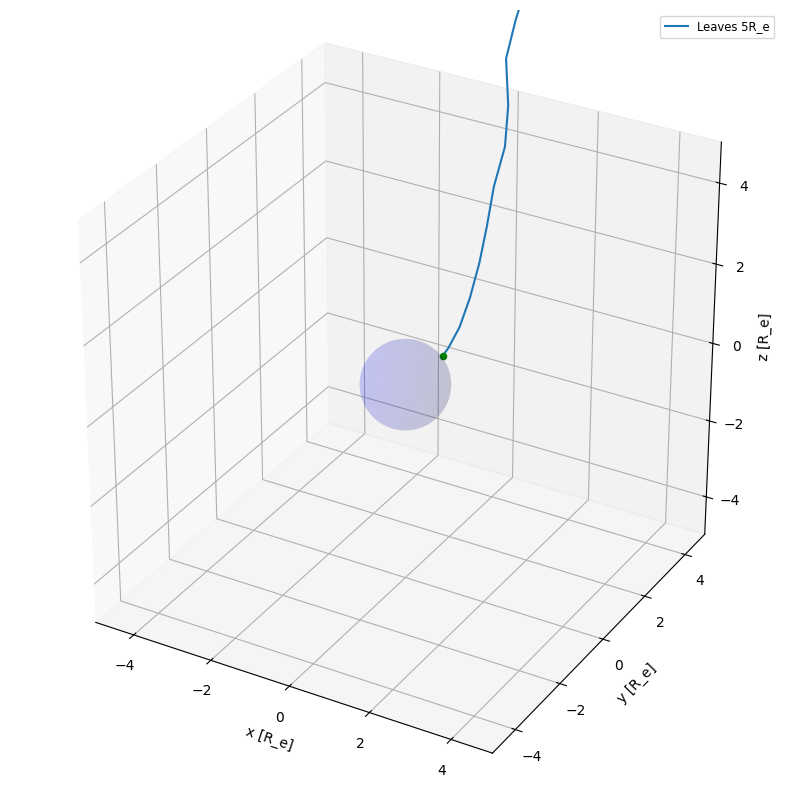

In [16]:
## Try the IGRF field
Y = []

# small shell around the earth
X0 = np.array([3.8e6, 3.8e6, 3.8e6])
V0 = np.array([0, -5e5, -2e6])
Y0 = np.concatenate((X0, V0))
Y.append(Y0)

DEBUG = False
multi_tracking(IGRF_field, y_0=Y, time_range=[0, 100], n_steps=1000, do_clip_trajectory=True)

Using random initial conditions
Clipping at index 10
Clipping at index 13
Clipping at index 9
Using random initial conditions
v = 340674477.0362899 > c, setting 1/gamma = 0
v = 401269589.631598 > c, setting 1/gamma = 0
v = 312288481.6937296 > c, setting 1/gamma = 0
Clipping at index 10
Clipping at index 26
Using random initial conditions
v = 306440565.2087 > c, setting 1/gamma = 0
v = 642450276.8000511 > c, setting 1/gamma = 0
v = 617767947.118529 > c, setting 1/gamma = 0
v = 333807987.73888427 > c, setting 1/gamma = 0
v = 339112576.71538204 > c, setting 1/gamma = 0
v = 406808499.5696337 > c, setting 1/gamma = 0
v = 317934550.66556203 > c, setting 1/gamma = 0
v = 365695070.47576296 > c, setting 1/gamma = 0
v = 313879794.87158203 > c, setting 1/gamma = 0
v = 375084641.3955317 > c, setting 1/gamma = 0
v = 322905999.1049918 > c, setting 1/gamma = 0
v = 327075058.7198746 > c, setting 1/gamma = 0
v = 384890880.75193006 > c, setting 1/gamma = 0
v = 449055950.58919585 > c, setting 1/gamma = 0

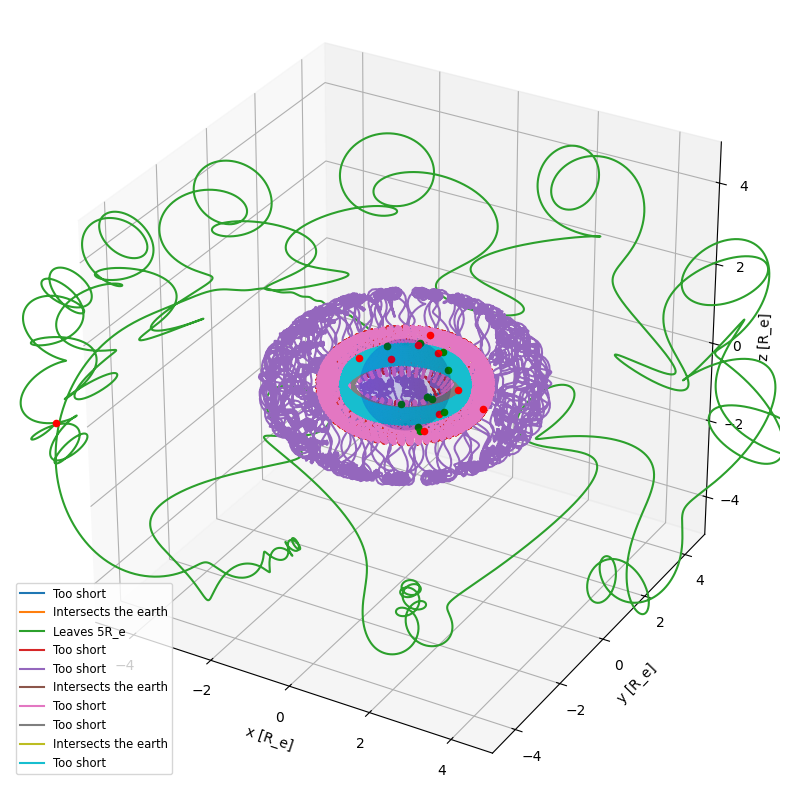

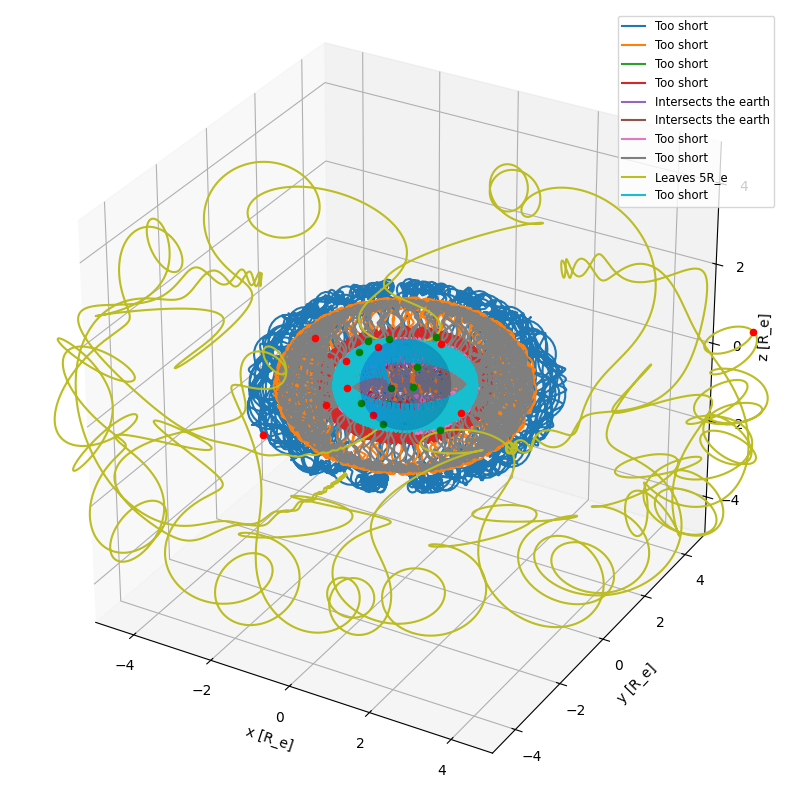

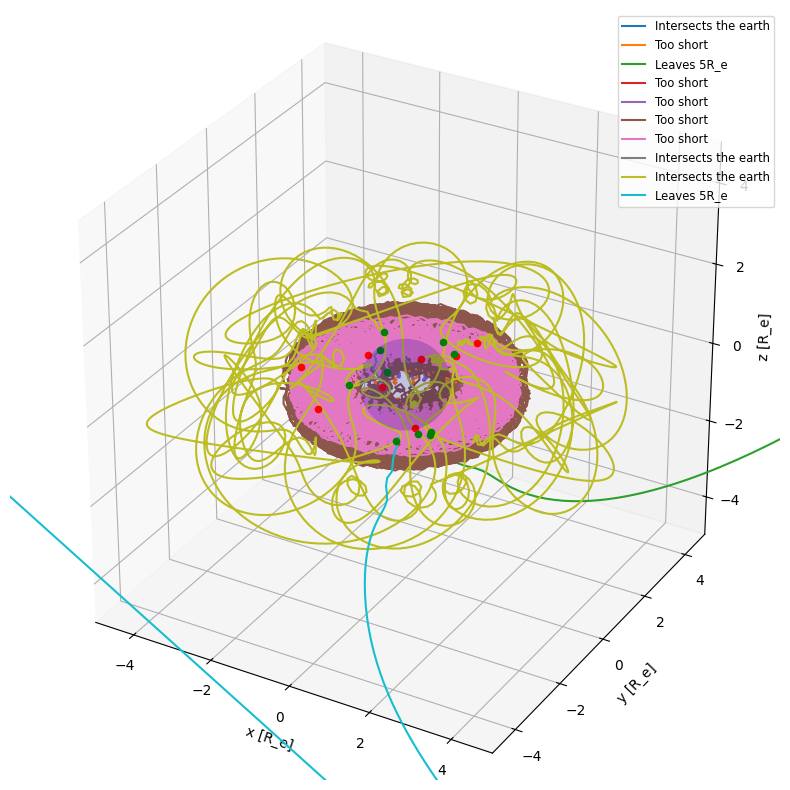

In [ ]:
multi_tracking(
    b_field_function = dipole_field,
    x_0_val=7e6,
    v_0_val=energy_to_speed(5e6), # 5 MeV
    # seed = 234982,
    repetitions = 10,
    time_range = [0, 50],
    n_steps = 10000,
    do_clip_trajectory = True,
)

multi_tracking(
    b_field_function = dipole_field,
    x_0_val=8e6,
    v_0_val=energy_to_speed(1e7), # 10 MeV
    # seed = 234982,
    repetitions = 10,
    time_range = [0, 50],
    n_steps = 10000,
    do_clip_trajectory = True,
)

# note how numerical stability becomes an issue
multi_tracking(
    b_field_function = dipole_field,
    x_0_val=8e6,
    v_0_val=energy_to_speed(1e9), # 1 GeV
    # seed = 234982,
    repetitions = 10,
    time_range = [0, 50],
    n_steps = 10000,
    do_clip_trajectory = True,
)

### Some statistics
A naive computation of the geomangetic cutoff:
- backtrack particles to determine whether they are of atmospheric or cosmic origin
- repeat for a range of energies
- (hopefully) find penumbra of the geomagnetic cutoff


### Appendix - coordinate systems
The IGRF is usually computed in *geodetic* coordinates: the Earth is an ellipse and the coordinate axis follow the ellipsoid. 

To simplify the computation, we will use *geocentric* coordinates where we consider the Earth as a sphere.

In the following we will express vectors in the following 3D coordinate system:
- the origin is the center of the Earth
- r is given in km
- theta is given in degrees (corresponds to colatitudes) -> -90 to 90
- phi is given in degrees (corresponds to longitudes) -> -180 to 180


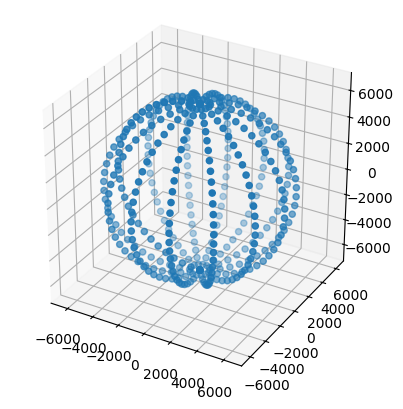

In [12]:
## Example - the spherical earth
# generate a grid of points that correspond to the surface of the earth
n = 15
lat_range = np.linspace(-90, 90, 2*n)
lon_range = np.linspace(-180, 180, n)
lat, lon = np.meshgrid(lat_range, lon_range)
lat = lat.flatten()
lon = lon.flatten()

# map to cartesian coordinates for plotting
r = 6.4e3
x = r * np.cos(np.radians(lat)) * np.cos(np.radians(lon))
y = r * np.cos(np.radians(lat)) * np.sin(np.radians(lon))
z = r * np.sin(np.radians(lat))

# plot the grid
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect([1,1,1])
ax.scatter(x, y, z)
plt.show()